# Clasificación y Optimización de Hiperparámetros (Core)


## Objetivo:
Implementar un pipeline completo de machine learning para un problema de clasificación utilizando técnicas de preprocesamiento, modelado, y optimización de hiperparámetros. Enfocar especialmente en la limpieza de datos y la optimización utilizando GridSearchCV y RandomizedSearchCV.



## Dataset:
https://www.kaggle.com/datasets/mirichoi0218/insurance

**age**: age of primary beneficiary

**sex**: insurance contractor gender, female, male

**bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

**children**: Number of children covered by health insurance / Number of dependents

**smoker**: Smoking

**region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

    --> Variable objetivo
**charges**: Individual medical costs billed by health insurance


### Descripción del Dataset:
El dataset de costos médicos personales contiene información sobre varios factores que afectan los costos de seguros médicos, como la edad, el sexo, el índice de masa corporal, y el hábito de fumar. Este dataset es ideal para practicar técnicas de preprocesamiento y optimización de modelos debido a la presencia de datos sucios y variables tanto categóricas como numéricas.

# 1) Carga y Exploración Inicial de Datos:
- Cargar el dataset desde Kaggle.
- Realizar una exploración inicial para entender la estructura del dataset y las características disponibles.
- Identificar y documentar los valores faltantes y outliers en el dataset.

In [1]:
# Instalar la API de Kaggle
!pip install kaggle

# Crear el directorio para las credenciales de Kaggle
!mkdir -p ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d mirichoi0218/insurance
!unzip insurance.zip

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0
  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 31.6MB/s]
Archive:  insurance.zip
  inflating: insurance.csv           


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lee el archivo CSV
df = pd.read_csv('insurance.csv')

In [44]:
# Exploración inicial
print(df.info())
print("\n")
print(df.describe(include='all').round(2))
print("\n")
print("Valores nulos:")
print(df.isnull().sum() * 100 / len(df))
print("\n")
print("Valores duplicados:")
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


            age   sex      bmi  children smoker     region   charges
count   1338.00  1338  1338.00   1338.00   1338       1338   1338.00
unique      NaN     2      NaN       NaN      2          4       NaN
top         NaN  male      NaN       NaN     no  southeast       NaN
freq        NaN   676      NaN       NaN   1064        364       NaN
mean      39.21   NaN    30.66      1.09    NaN        NaN  13270.42
std       14.05   NaN     6.10      1.21    NaN        NaN 

In [45]:
# Detectar outliers en variables numéricas (no está incluida selección de columnas numéricas)
def outliers_IQR(df):
    for col in df:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1               # Interquartile range

        # Definir los límites inferior y superior de los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in {col}: {outliers.shape[0]}")

        # Opcional: Remover outliers
        # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# ***IQR (Rango Intercuartílico)*** medida de dispersión estadística que ayuda a ID valores atípicos (outliers)

outliers_IQR(df.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in age: 0

🚩 Outliers detected in bmi: 9

🚩 Outliers detected in children: 0

🚩 Outliers detected in charges: 139


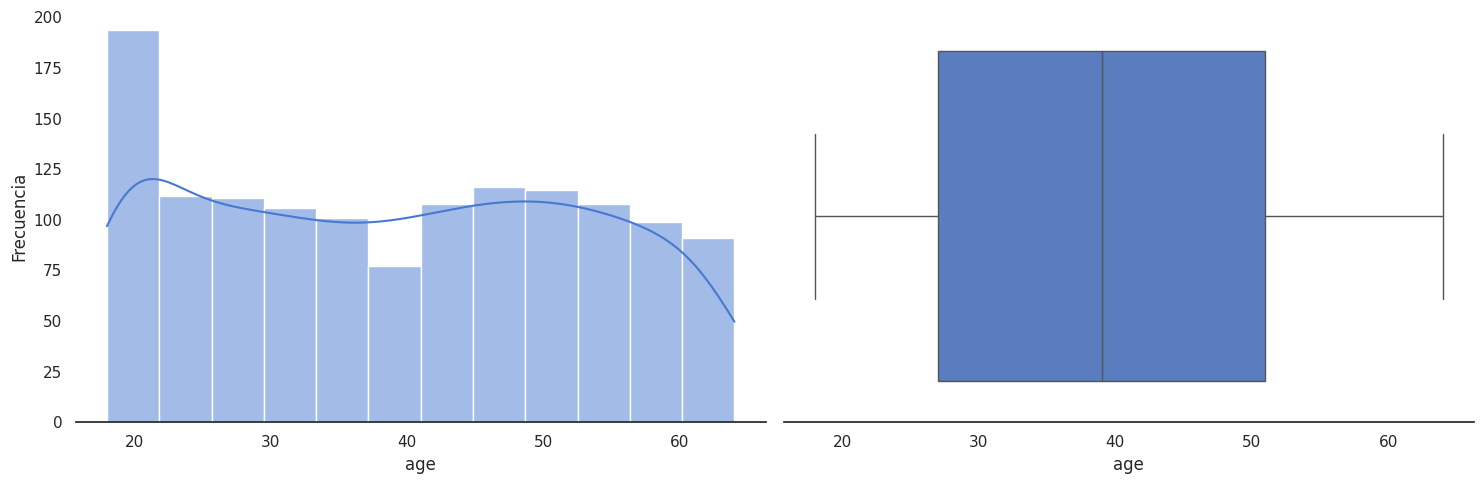

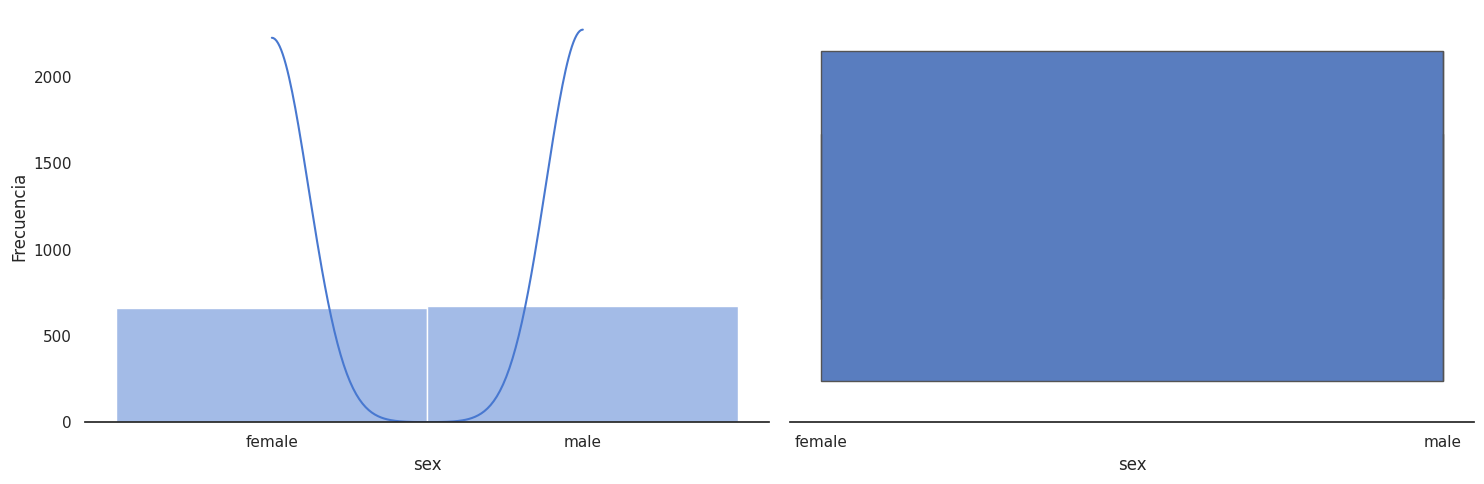

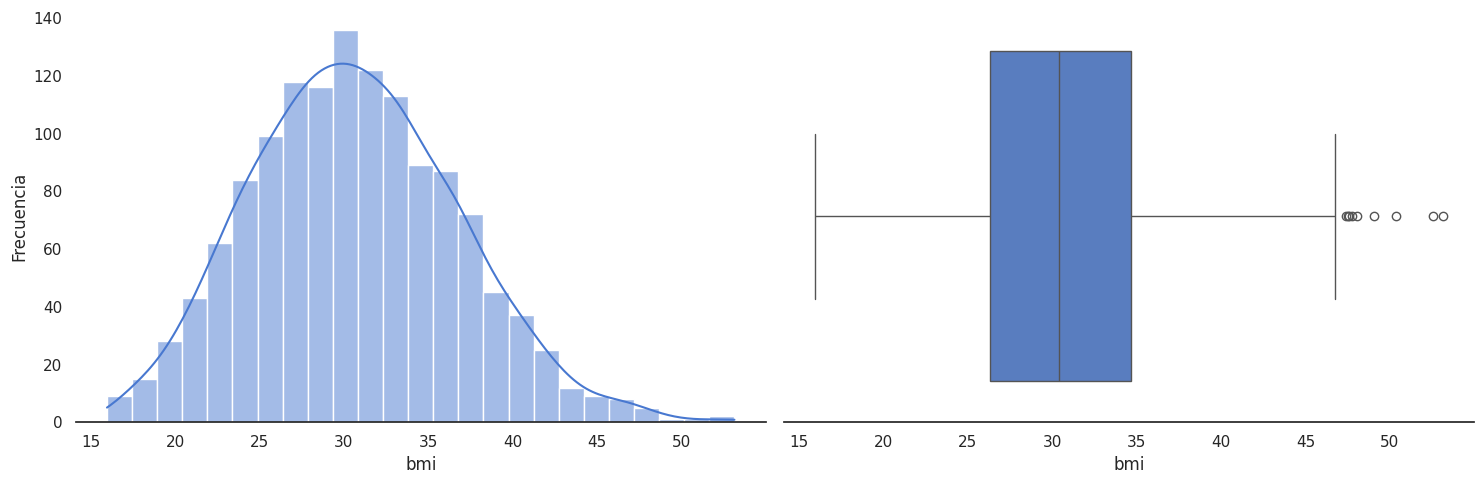

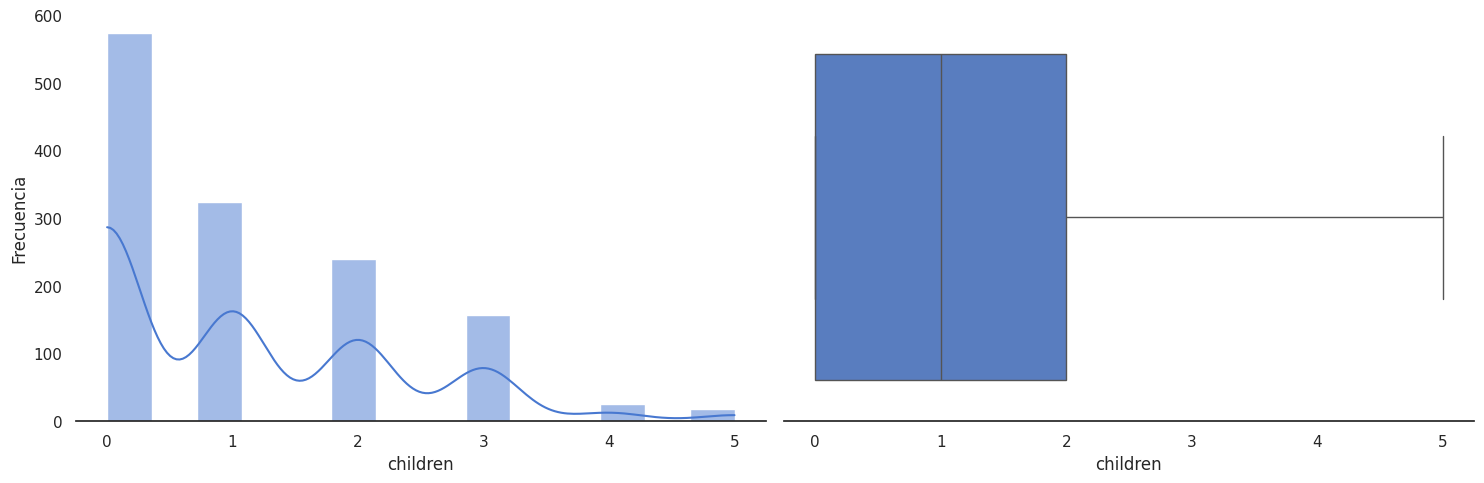

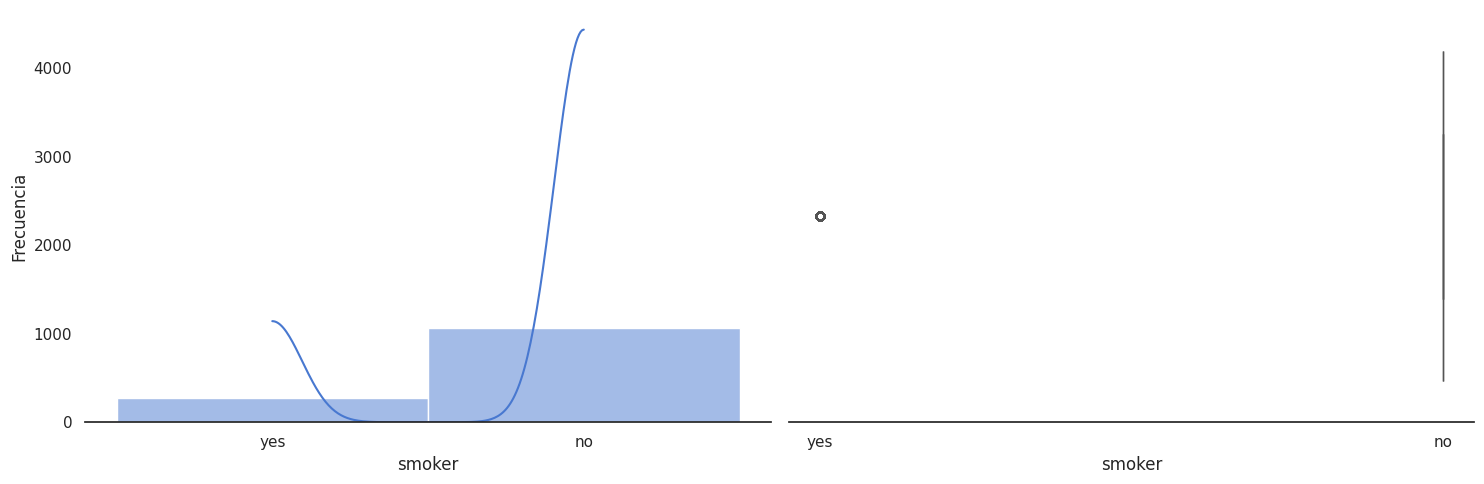

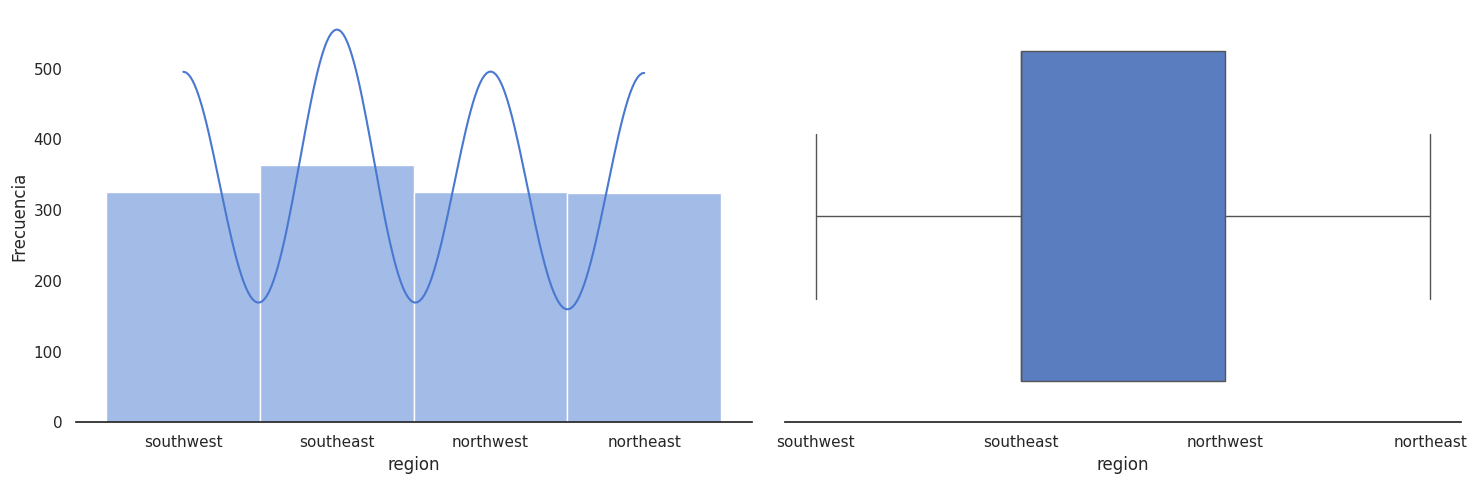

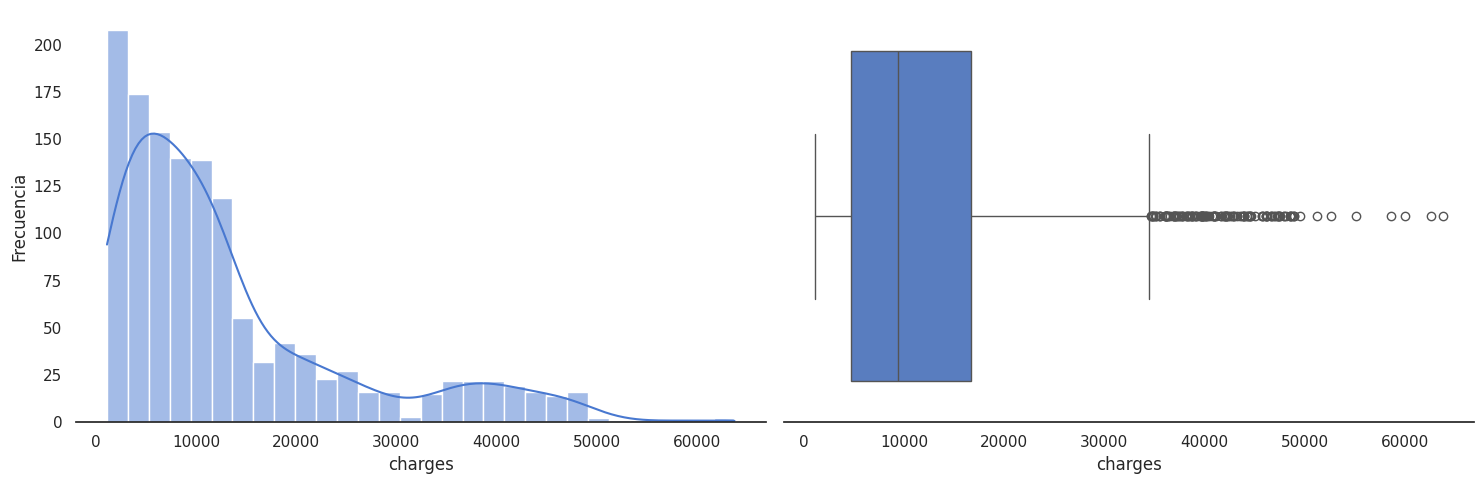

In [46]:
def vis_hist_boxplot(df):
    for i in df.columns:
        fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)

        # Histograma con kde
        sns.histplot(data=df, x=i, kde=True, ax=ax[0]).set_xlabel(f"{i}")
        ax[0].set_ylabel('Frecuencia')
        # Boxplot
        sns.boxplot(data=df, x=i, ax=ax[1])

        plt.tight_layout()
        plt.show()

vis_hist_boxplot(df)

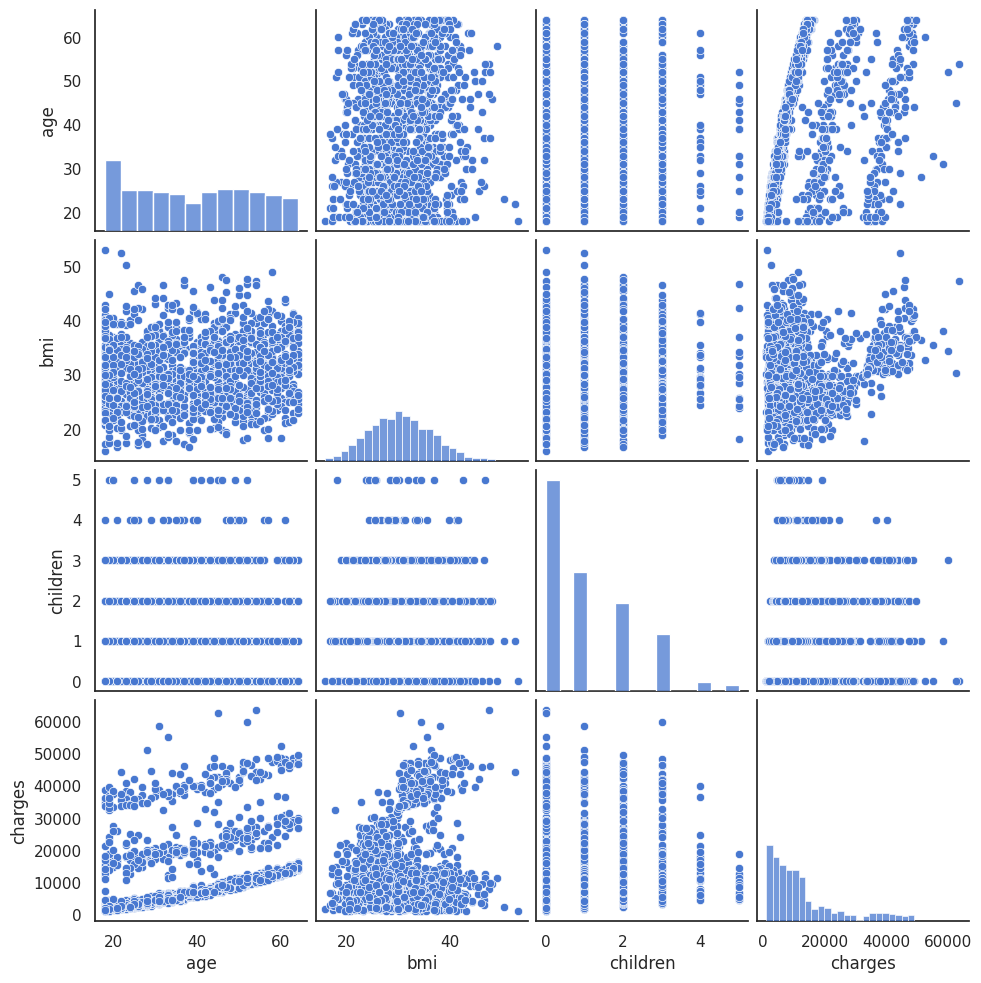

In [47]:
sns.pairplot(df)

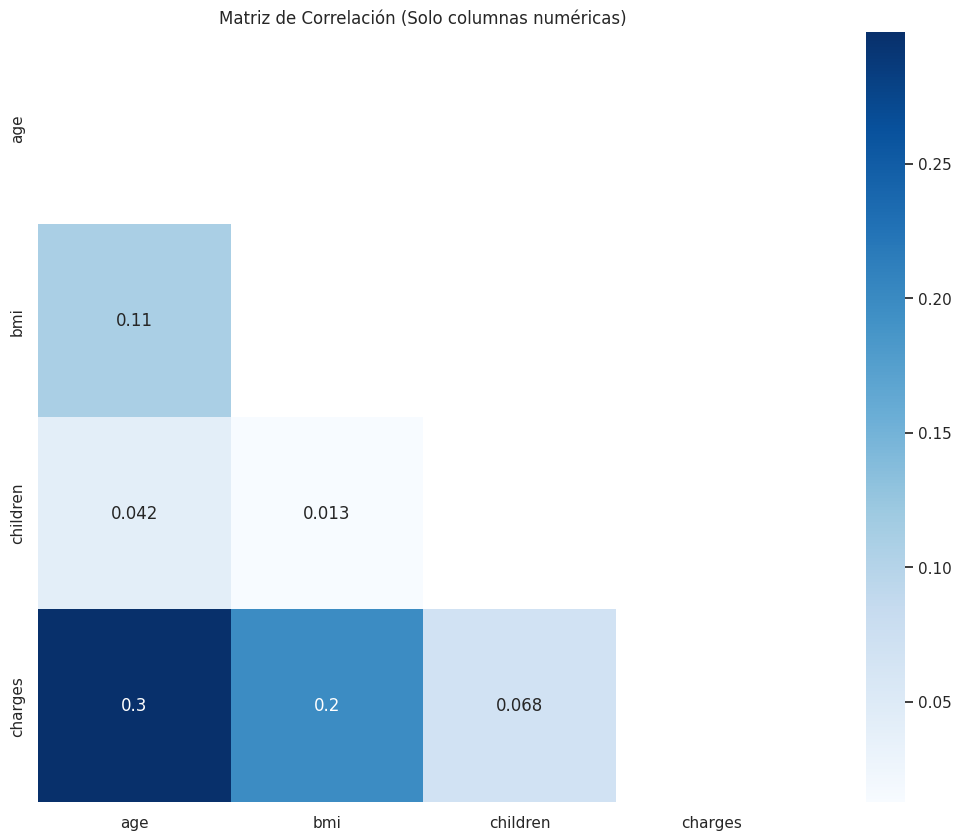

In [48]:
# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Crear una máscara para ocultar la parte superior del triángulo
mask = np.zeros_like(df_numeric.corr())
tri_ind = np.triu_indices_from(mask)
mask[tri_ind] = True

# Configurar el tamaño de la figura y graficar el heatmap
plt.figure(figsize=[15, 10])
sns.heatmap(data=df_numeric.corr(), annot=True, mask=mask, cmap='Blues', square=True)
plt.title('Matriz de Correlación (Solo columnas numéricas)')
plt.show()

In [49]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(var1, var2):
    crosstab = pd.crosstab(var1, var2)
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    min_dim = min(crosstab.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Seleccionar todas las columnas categóricas excepto la variable objetivo
target_col = 'smoker'
categorical_cols = df.select_dtypes(include=['object','int','float']).columns
other_cols = [col for col in categorical_cols if col != target_col]

# Calcular V de Cramer para cada columna con respecto a AI_Satisfication
cramer_scores = {}
for col in other_cols:
    cramer_scores[col] = cramers_v(df[target_col], df[col])

# Convertir a Series y ordenar
cramer_results = pd.Series(cramer_scores).sort_values(ascending=False)

print(f"\nAsociaciones con {target_col} usando V de Cramer:")
print(cramer_results)

# V de Cramer: medida estadística evalúa fuerza de asociación entre variables categóricas, basada en estadística chi-cuadrado.
# Sus valores van de 0 a 1, donde: 0 significa que no hay asociación, 1 significa una asociación perfecta…
# < 0.1: asociación muy débil, 0.1 - 0.3: asociación débil, 0.3 - 0.5: asociación moderada, >0.5: asociación fuerte

# La ventaja del V de Cramer es que:
# Funciona con variables categóricas de cualquier número de categorías
# Es simétrica (el orden de las variables no importa)
# Es normalizada (siempre va de 0 a 1)
# No asume ninguna distribución específica de los datos


Asociaciones con smoker usando V de Cramer:
charges     1.000000
bmi         0.653676
age         0.197950
sex         0.074333
region      0.074084
children    0.071748
dtype: float64


In [50]:
# Eliminar duplicados
df = df.drop_duplicates()
print(f"\nValores duplicados después de la eliminación: {df.duplicated().sum()}")


Valores duplicados después de la eliminación: 0


In [51]:
# Aplicar transformación logarítmica a 'charges' por su distribución con sesgo extremo a la derecha
df['charges'] = np.log1p(df['charges'])

# Aplicar transformación cuadrática a 'bmi' con distribución normal y sesgo a la derecha (pequeño)
df['bmi'] = np.sqrt(df['bmi'])

<ipython-input-51-1e58ce79866c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['charges'] = np.log1p(df['charges'])
<ipython-input-51-1e58ce79866c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi'] = np.sqrt(df['bmi'])


In [52]:
outliers_IQR(df.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in age: 0

🚩 Outliers detected in bmi: 3

🚩 Outliers detected in children: 0

🚩 Outliers detected in charges: 0


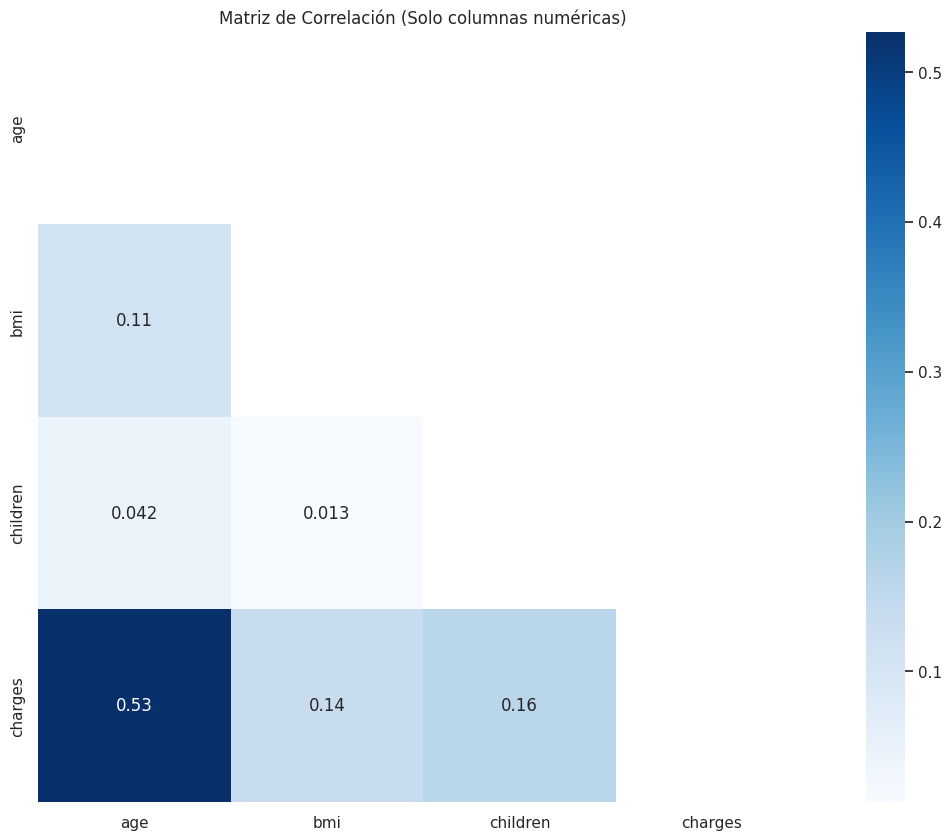

In [53]:
# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Crear una máscara para ocultar la parte superior del triángulo
mask = np.zeros_like(df_numeric.corr())
tri_ind = np.triu_indices_from(mask)
mask[tri_ind] = True

# Configurar el tamaño de la figura y graficar el heatmap
plt.figure(figsize=[15, 10])
sns.heatmap(data=df_numeric.corr(), annot=True, mask=mask, cmap='Blues', square=True)
plt.title('Matriz de Correlación (Solo columnas numéricas)')
plt.show()

In [54]:
# Seleccionar todas las columnas categóricas excepto la variable objetivo
target_col = 'smoker'
categorical_cols = df.select_dtypes(include=['object','int','float']).columns
other_cols = [col for col in categorical_cols if col != target_col]

# Calcular V de Cramer para cada columna con respecto a AI_Satisfication
cramer_scores = {}
for col in other_cols:
    cramer_scores[col] = cramers_v(df[target_col], df[col])

# Convertir a Series y ordenar
cramer_results = pd.Series(cramer_scores).sort_values(ascending=False)

print(f"\nAsociaciones con {target_col} usando V de Cramer:")
print(cramer_results)


Asociaciones con smoker usando V de Cramer:
charges     1.000000
bmi         0.653591
age         0.198307
sex         0.074743
region      0.073780
children    0.071699
dtype: float64


## Análisis:

-	Se cargó el dataset desde Kaggle y se realizó la exploración inicial

-	1338 entradas en 7 columnas, 3 categóricas y 4 numéricas, no hay nulos, hay 1 duplicado, y parece haber outliers en ‘bmi’ y ‘charges’, y se trataron con transformaciones diferentes para ambas variables

-	Si bien en un inicio, la variable ‘charges’ tiene correlación con bmi (0.2) y age (0.3), no precisamente altas, cuando se revisa con otras metodologías  se ve que para la variable ‘smoker’ la cual es categórica con dos valores (yes/no) con clases desbalanceadas, tiene una correlación de 1 con ‘charges’, pero también tiene correlación con bmi (0.6), age (0.19) y con el resto de variables (0.07)

-	Después de realizar las transformaciones, la correlaciones cambian si la variable objetivo es ‘chages’, y no lo hacen cuando es ‘smoker’

-	Dado que el objetivo es realizar clasificación y no regresión, se escoge la variable objetivo como ‘smoker’, además de su alta correlación con ‘charges’, en términos simples, sería lo mismo tomar cualquiera de las dos variables, aunque la metodología de modelado es diferente.



# 2) Preprocesamiento de Datos:
- Imputar valores faltantes utilizando técnicas adecuadas (media, mediana, moda, imputación avanzada).
- Codificar variables categóricas utilizando One-Hot Encoding.
- Escalar características numéricas utilizando StandardScaler.

In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar las características (X) y la variable objetivo (y)
X = df.drop('smoker', axis=1)
y = df['smoker']

# Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Crear transformadores para características numéricas y categóricas
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Aplicar el preprocesamiento a las características
X_processed = preprocessor.fit_transform(X)

# 3) Implementación de Modelos de Clasificación:
- Entrenar y evaluar al menos tres modelos de clasificación diferentes: Regresión Logística, K-Nearest Neighbors (KNN), y Árbol de Decisión.
- Utilizar validación cruzada para evaluar el rendimiento inicial de los modelos.

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Crear instancias de los modelos
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Entrenar y evaluar los modelos con validación cruzada
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"--- {name} ---")
    print(f"Puntajes de validación cruzada: {cv_scores}")
    print(f"Promedio de puntajes de validación cruzada: {np.mean(cv_scores)}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Precisión en el conjunto de prueba: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")

--- Logistic Regression ---
Puntajes de validación cruzada: [0.94392523 0.96728972 0.95327103 0.97196262 0.96713615]
Promedio de puntajes de validación cruzada: 0.9607169496731165
Precisión en el conjunto de prueba: 0.9776119402985075
              precision    recall  f1-score   support

          no       1.00      0.97      0.99       208
         yes       0.91      1.00      0.95        60

    accuracy                           0.98       268
   macro avg       0.95      0.99      0.97       268
weighted avg       0.98      0.98      0.98       268

[[202   6]
 [  0  60]]


--- KNN ---
Puntajes de validación cruzada: [0.92056075 0.90186916 0.90186916 0.91588785 0.90140845]
Promedio de puntajes de validación cruzada: 0.9083190733184152
Precisión en el conjunto de prueba: 0.9365671641791045
              precision    recall  f1-score   support

          no       0.95      0.97      0.96       208
         yes       0.88      0.83      0.85        60

    accuracy                  

# 4) Optimización de Hiperparámetros:
- Implementar GridSearchCV para optimizar los hiperparámetros de los modelos seleccionados.
- Implementar RandomizedSearchCV como método alternativo de optimización.
- Comparar los resultados de GridSearchCV y RandomizedSearchCV para los modelos optimizados.

In [70]:
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].value_counts())
    print("-" * 20)

Column: age
age
18    69
19    67
50    29
51    29
47    29
46    29
45    29
20    29
48    29
52    29
22    28
49    28
54    28
53    28
21    28
26    28
24    28
25    28
28    28
27    28
23    28
43    27
29    27
30    27
41    27
42    27
44    27
31    27
40    27
32    26
33    26
56    26
34    26
55    26
57    26
37    25
59    25
58    25
36    25
38    25
35    25
39    25
61    23
60    23
63    23
62    23
64    22
Name: count, dtype: int64
--------------------
Column: sex
sex
male      675
female    662
Name: count, dtype: int64
--------------------
Column: bmi
bmi
5.683309    13
5.320714     9
5.549775     8
5.599107     8
5.374012     8
            ..
6.797058     1
4.878524     1
6.691039     1
5.667451     1
5.565070     1
Name: count, Length: 548, dtype: int64
--------------------
Column: children
children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64
--------------------
Column: smoker
smoker
no     1063
yes     274
Name: cou

In [74]:
import pandas as pd

# Assuming X_train and X_test are already defined as pandas DataFrames or Series
# from the previous code.

def unique_value_counts(data):
  """
  Calculates unique values and their counts in a DataFrame or Series.

  Args:
      data: pandas DataFrame or Series.

  Returns:
      A DataFrame containing unique values and their counts for each column.
  """

  if isinstance(data, pd.Series):
    return pd.DataFrame({'value': data.unique(), 'count': data.value_counts().values})

  results = []
  for col in data.columns:
    unique_values = data[col].unique()
    counts = data[col].value_counts().values
    results.append(pd.DataFrame({'column': [col] * len(unique_values),
                                  'value': unique_values,
                                  'count': counts}))

  return pd.concat(results, ignore_index=True)

# Example usage (replace with your actual X_train and X_test):
# Assuming 'X_train' and 'X_test' are defined in the preceding code.

X_train_unique_counts = unique_value_counts(X_train)
X_test_unique_counts = unique_value_counts(X_test)

print("Unique value counts in X_train:")
print(X_train_unique_counts)

print("\nUnique value counts in X_test:")
print(X_test_unique_counts)

Unique value counts in X_train:
       column      value  count
0         age         23     55
1         age         21     52
2         age         52     26
3         age         63     26
4         age         47     25
...       ...        ...    ...
1622  charges  10.706435      1
1623  charges   8.214581      1
1624  charges   7.583644      1
1625  charges    8.87516      1
1626  charges   8.672061      1

[1627 rows x 3 columns]

Unique value counts in X_test:
      column     value  count
0        age        49     17
1        age        29     12
2        age        51     12
3        age        31      9
4        age        23      8
..       ...       ...    ...
526  charges  9.534748      1
527  charges  9.538795      1
528  charges  8.275569      1
529  charges  10.76648      1
530  charges  9.052009      1

[531 rows x 3 columns]


In [75]:
# Check for NaN values in X_train_unique_counts
print(X_train_unique_counts.isnull().sum())

# Check for NaN values in X_test_unique_counts
print(X_test_unique_counts.isnull().sum())

column    0
value     0
count     0
dtype: int64
column    0
value     0
count     0
dtype: int64



Optimizando Logistic Regression:

Resultados para Logistic Regression:

GridSearchCV:
Mejores parámetros: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__solver': 'liblinear'}
Mejor score CV: 0.9617
Score en test: 0.9776

RandomizedSearchCV:
Mejores parámetros: {'classifier__C': 14.287681792194077, 'classifier__max_iter': 230, 'classifier__solver': 'liblinear'}
Mejor score CV: 0.9617
Score en test: 0.9739

Optimizando KNN:

Resultados para KNN:

GridSearchCV:
Mejores parámetros: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 11, 'classifier__weights': 'distance'}
Mejor score CV: 0.9205
Score en test: 0.9552

RandomizedSearchCV:
Mejores parámetros: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 10, 'classifier__weights': 'distance'}
Mejor score CV: 0.9195
Score en test: 0.9515

Optimizando Decision Tree:

Resultados para Decision Tree:

GridSearchCV:
Mejores parámetros: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'clas

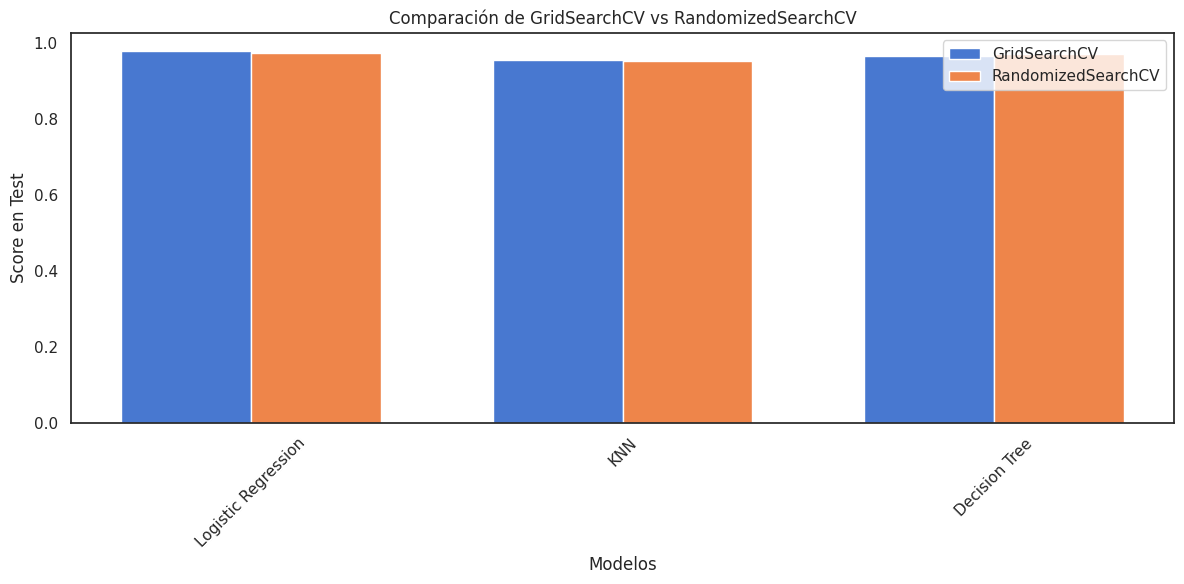

In [78]:
# código dado por Claude

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
import numpy as np
import matplotlib.pyplot as plt

# Separar las características (X) y la variable objetivo (y)
X = df.drop('smoker', axis=1)
y = df['smoker']

# Identificar columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Crear transformadores para características numéricas y categóricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Agregar imputación para valores numéricos
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Agregar imputación para categóricos
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar transformadores usando ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Crear pipelines completos para cada modelo
models = {
    "Logistic Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    "KNN": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ])
}

# Definir los espacios de búsqueda para cada modelo
param_grids = {
    "Logistic Regression": {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__max_iter': [100, 200, 300],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    "KNN": {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Decision Tree": {
        'classifier__max_depth': [3, 5, 7, 10, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
}

# Definir distribuciones para RandomizedSearchCV
param_distributions = {
    "Logistic Regression": {
        'classifier__C': uniform(0.001, 100),
        'classifier__max_iter': randint(100, 500),
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    "KNN": {
        'classifier__n_neighbors': randint(1, 20),
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    "Decision Tree": {
        'classifier__max_depth': randint(1, 20),
        'classifier__min_samples_split': randint(2, 20),
        'classifier__min_samples_leaf': randint(1, 10)
    }
}

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Diccionario para almacenar resultados
results = {}

# Realizar búsqueda de hiperparámetros para cada modelo
for name, model in models.items():
    print(f"\nOptimizando {name}:")

    # GridSearchCV
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model,
        param_distributions[name],
        n_iter=20,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train, y_train)

    # Guardar resultados
    results[name] = {
        'grid_search': {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'test_score': grid_search.score(X_test, y_test)
        },
        'random_search': {
            'best_params': random_search.best_params_,
            'best_score': random_search.best_score_,
            'test_score': random_search.score(X_test, y_test)
        }
    }

    # Imprimir resultados comparativos
    print(f"\nResultados para {name}:")
    print("\nGridSearchCV:")
    print(f"Mejores parámetros: {results[name]['grid_search']['best_params']}")
    print(f"Mejor score CV: {results[name]['grid_search']['best_score']:.4f}")
    print(f"Score en test: {results[name]['grid_search']['test_score']:.4f}")

    print("\nRandomizedSearchCV:")
    print(f"Mejores parámetros: {results[name]['random_search']['best_params']}")
    print(f"Mejor score CV: {results[name]['random_search']['best_score']:.4f}")
    print(f"Score en test: {results[name]['random_search']['test_score']:.4f}")

# Visualizar comparación de resultados
plt.figure(figsize=(12, 6))
x = np.arange(len(models))
width = 0.35

grid_scores = [results[model]['grid_search']['test_score'] for model in models]
random_scores = [results[model]['random_search']['test_score'] for model in models]

plt.bar(x - width/2, grid_scores, width, label='GridSearchCV')
plt.bar(x + width/2, random_scores, width, label='RandomizedSearchCV')

plt.xlabel('Modelos')
plt.ylabel('Score en Test')
plt.title('Comparación de GridSearchCV vs RandomizedSearchCV')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Análisis:
-	Realmente intenté realizar varios códigos sin mucho esfuerzo, incluso mirando algo con GPT para revisar donde estaban los errores, pero nunca pude encontrar el error en lo que estaba haciendo, básicamente, no me corría ningún código que estaba haciendo para GridSearchCV o RandomizedSearchCV, el error siempre me decía que no podía procesar “NaN”, por eso los primeros bloques de este bloque revisan ello, pero no encontré que era lo que sucedía.

-	El último código (bastante largo por cierto) fue realizado por **Claude** y si funcionó, en este se realizan varios flujos con Pipeline y ColumnTranformer supongo que para evitar que suceda esto de que al hacer algo con las características se generen los NaN, se aplican los modelos y se modifican hiperparámetros para ellos según GridSearchCV y RandomizedSearchCV, se guardan los resultados en un diccionario y se imprimen los resultados, además se hacen visualizaciones de comparación

-	Según los resultados

1. Regresión Logística (mejor rendimiento general):

-	GridSearchCV:
    -	Mejores hiperparámetros: C=10, max_iter=100, solver='liblinear'
    -	Score en validación cruzada: 96.17%
    -	Score en test: 97.76% (el mejor)
-	RandomizedSearchCV:
    -	Encontró parámetros similares: C≈14.29, max_iter=230, mismo solver
    -	Rendimiento prácticamente idéntico (97.39% en test)

2. KNN (rendimiento más bajo de los tres):
- Ambos métodos encontraron configuraciones similares:
    -	Métrica euclidiana
    -	10-11 vecinos
    -	Pesos por distancia
-	Scores más bajos: ~92% en CV y ~95% en test
-	GridSearch ligeramente mejor que Random (95.52% vs 95.15%)

3.   Árbol de Decisión:
-	Ambos métodos coinciden en un árbol poco profundo (max_depth=3)
-	Parámetros similares para las hojas y splits
-	Rendimiento muy bueno: ~96% en CV y ~97% en test
-	GridSearch ligeramente superior (97.39% vs 97.01%)

**Conclusiones principales:**
1.	La Regresión Logística es el mejor modelo para este problema

2.	GridSearchCV generalmente obtuvo resultados ligeramente mejores que RandomizedSearchCV

3.	Todos los modelos tienen un excelente rendimiento (>95% en test)

4.	La diferencia entre validación cruzada y test es pequeña, lo que indica buena generalización

**Recomendación:**
Usar la Regresión Logística con los parámetros encontrados por GridSearchCV, ya que:

-	Tiene el mejor rendimiento

-	Es un modelo más simple que KNN

-	Es más interpretable que el árbol de decisión

-	Los parámetros son robustos (confirmado por ambos métodos de búsqueda)


# 5. Evaluación de Modelos:
- Evaluar los modelos optimizados utilizando métricas de rendimiento como exactitud, precisión, recall, F1-Score y ROC-AUC.
- Generar y analizar la matriz de confusión para los modelos optimizados.
- Crear y visualizar la curva ROC para evaluar la capacidad del modelo para distinguir entre clases.


Resultados para Logistic Regression:

Métricas principales:
Accuracy: 0.9776
Precision: 0.9091
Recall: 1.0000
F1-Score: 0.9524
ROC-AUC: 0.9916

Reporte de Clasificación:
              precision    recall  f1-score   support

          no       1.00      0.97      0.99       208
         yes       0.91      1.00      0.95        60

    accuracy                           0.98       268
   macro avg       0.95      0.99      0.97       268
weighted avg       0.98      0.98      0.98       268


Matriz de Confusión:
[[202   6]
 [  0  60]]


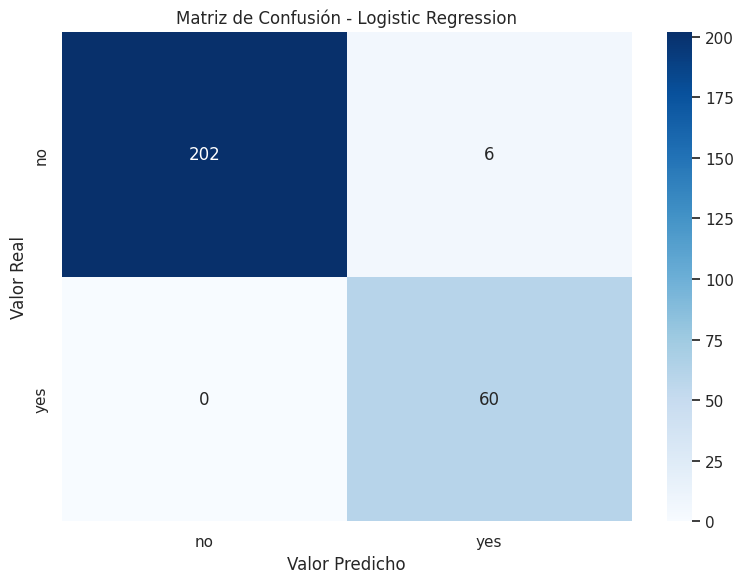


Resultados para KNN:

Métricas principales:
Accuracy: 0.9552
Precision: 0.9138
Recall: 0.8833
F1-Score: 0.8983
ROC-AUC: 0.9772

Reporte de Clasificación:
              precision    recall  f1-score   support

          no       0.97      0.98      0.97       208
         yes       0.91      0.88      0.90        60

    accuracy                           0.96       268
   macro avg       0.94      0.93      0.93       268
weighted avg       0.95      0.96      0.95       268


Matriz de Confusión:
[[203   5]
 [  7  53]]


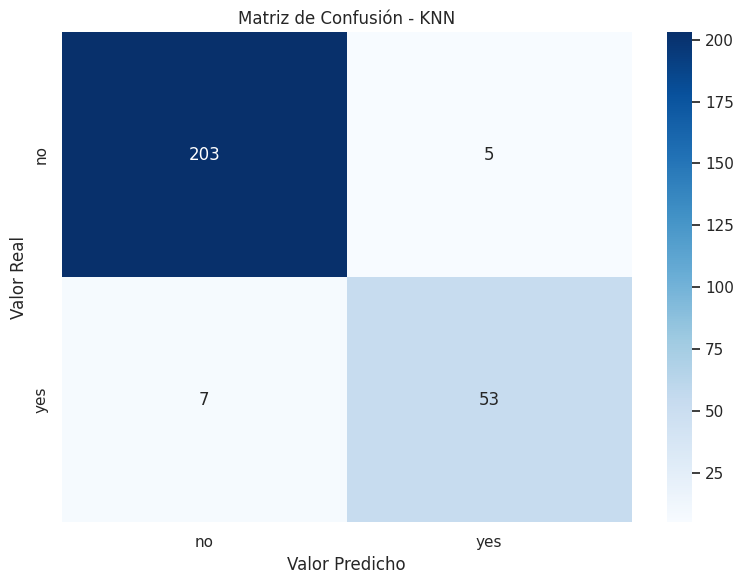


Resultados para Decision Tree:

Métricas principales:
Accuracy: 0.9664
Precision: 0.9048
Recall: 0.9500
F1-Score: 0.9268
ROC-AUC: 0.9852

Reporte de Clasificación:
              precision    recall  f1-score   support

          no       0.99      0.97      0.98       208
         yes       0.90      0.95      0.93        60

    accuracy                           0.97       268
   macro avg       0.95      0.96      0.95       268
weighted avg       0.97      0.97      0.97       268


Matriz de Confusión:
[[202   6]
 [  3  57]]


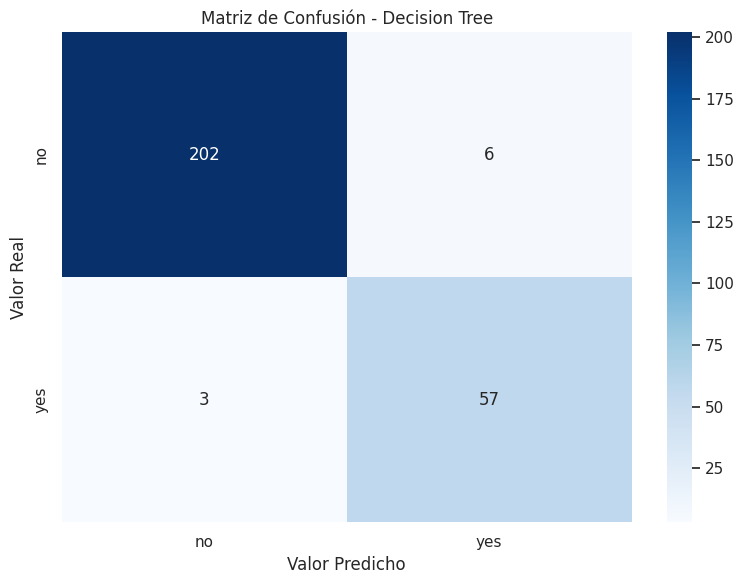


Comparación de métricas entre modelos:
           Logistic Regression     KNN  Decision Tree
Accuracy                0.9776  0.9552         0.9664
Precision               0.9091  0.9138         0.9048
Recall                  1.0000  0.8833         0.9500
F1-Score                0.9524  0.8983         0.9268
ROC-AUC                 0.9916  0.9772         0.9852


<Figure size 1200x600 with 0 Axes>

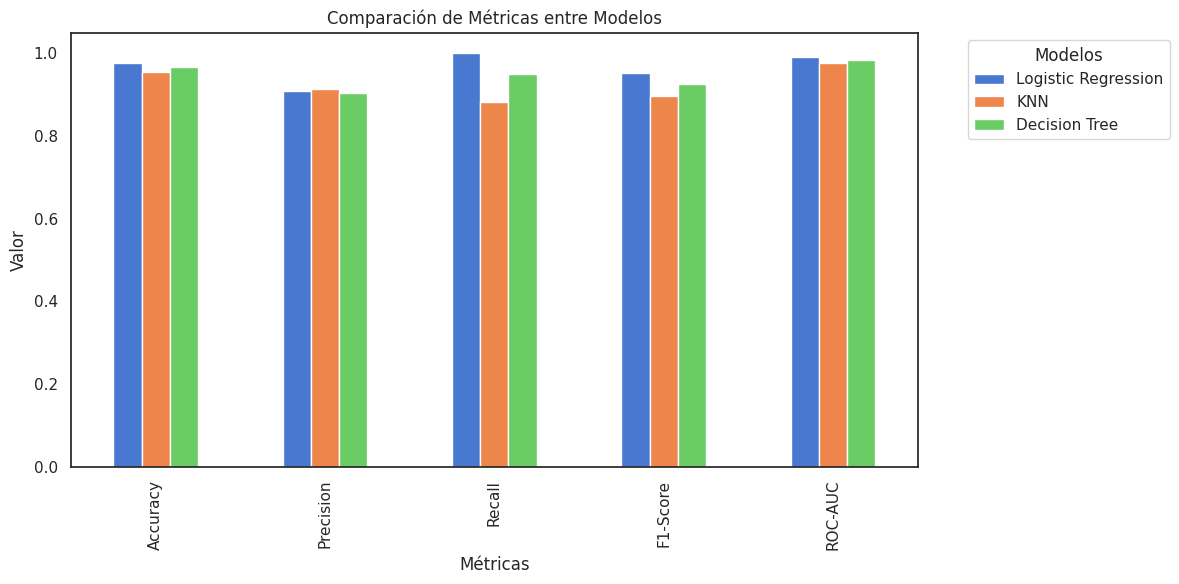


Generando curvas ROC...


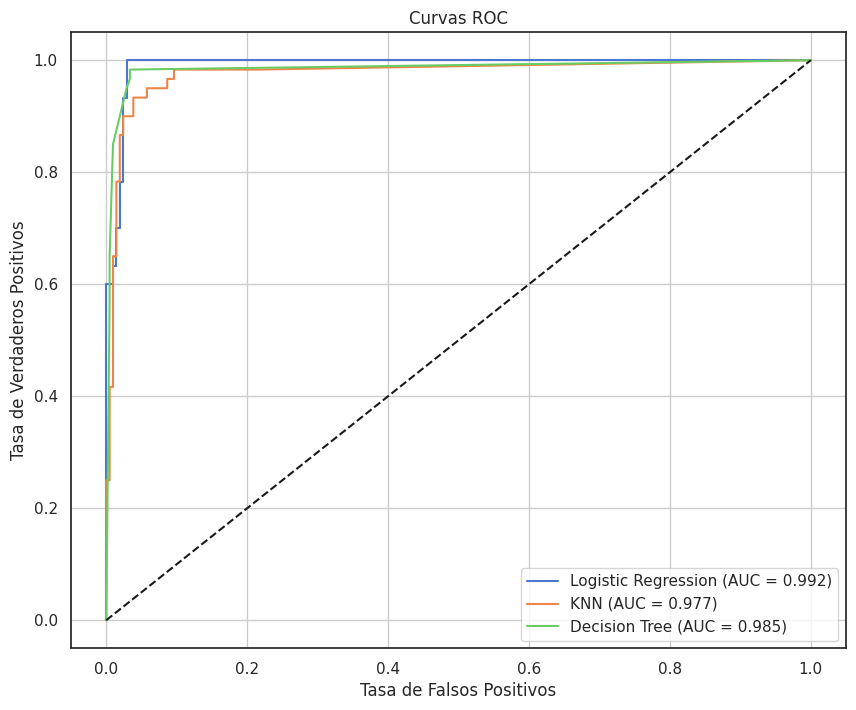

In [81]:
# Suponiendo que `models` sea un diccionario de modelos sin el `GridSearchCV` aún
models_dict = {name: model for name, model in models.items()}

# Realizar GridSearchCV y guardar el mejor modelo
best_models = {}

for name, model in models_dict.items():
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_  # Guardar el mejor modelo de cada búsqueda

# Evaluar los modelos optimizados
metrics_results = {}

for name, best_model in best_models.items():
    # Realizar predicciones
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Calcular métricas especificando pos_label='yes'
    metrics_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, pos_label='yes'),
        'Recall': recall_score(y_test, y_pred, pos_label='yes'),
        'F1-Score': f1_score(y_test, y_pred, pos_label='yes'),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba, labels=['no', 'yes'])
    }

    # Imprimir resultados detallados
    print(f"\nResultados para {name}:")
    print("\nMétricas principales:")
    for metric, value in metrics_results[name].items():
        print(f"{metric}: {value:.4f}")

    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Generar y visualizar matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=['no', 'yes'])
    print("\nMatriz de Confusión:")
    print(cm)
    plot_confusion_matrix(cm, name)

# Visualizar comparación de métricas
metrics_df = pd.DataFrame(metrics_results).round(4)
print("\nComparación de métricas entre modelos:")
print(metrics_df)

# Crear gráfico de barras para comparar métricas
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparación de Métricas entre Modelos')
plt.xlabel('Métricas')
plt.ylabel('Valor')
plt.legend(title='Modelos', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Generar curvas ROC
print("\nGenerando curvas ROC...")
plot_roc_curves(best_models, X_test, y_test)


## Análisis:
- Logistic Regression es el modelo con el mejor rendimiento global. Tiene el mejor accuracy, recall, y ROC-AUC, lo que indica que tiene un excelente balance entre precisión y sensibilidad.

- KNN muestra una buena precisión, pero su recall más bajo puede ser problemático en aplicaciones donde es crítico identificar todas las instancias positivas.

- Decision Tree tiene un buen desempeño general, con un buen balance de precisión, recall, y AUC, pero no supera a Logistic Regression en ninguna de las métricas clave.



Si el objetivo es minimizar los falsos negativos (mejor recall), la Logistic Regression sería la mejor opción.

Si por el contrario se busca un modelo que también tenga un buen rendimiento en la clasificación de la clase positiva, entonces KNN podría ser útil.

Sin embargo, Logistic Regression parece ser el modelo más equilibrado en este ejercicio.

# 6) Documentación y Entrega:
- Documentar todos los pasos del proceso en un notebook de Jupyter, incluyendo explicaciones detalladas y justificaciones para cada decisión tomada.
- Subir el notebook y los resultados a un repositorio de GitHub.
- Crear un tag de liberación (v1.0.0) para esta versión del proyecto en GitHub.

# Entregables:

- Notebook de Jupyter con todo el análisis y resultados.
- Documentación completa del proceso de preprocesamiento, modelado y optimización.
- Visualizaciones y análisis de las métricas de rendimiento.
- Repositorio de GitHub con el notebook y los resultados, incluyendo un tag de liberación.